<a href="https://colab.research.google.com/github/duttaprat/BMI_503/blob/main/class_1/notebook2_imagomics_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Class 1 - Notebook_2 Part 1: Medical Image Analysis
**Course**: BMI 503  
**Instructors**: Pratik Dutta   
**Institution**: Stony Brook University

## Learning Objectives
1. Understand what imagomics is
2. Process H&E pathology images
3. Detect and count cells
4. Extract quantitative features

## What is Imagomics?

**Imagomics** = Image-based omics analysis

### The Problem
Traditional omics lose spatial context:
- 🧬 Genomics: DNA sequences, but WHERE?
- 📊 Transcriptomics: Gene expression, but WHICH cells?
- 🧪 Proteomics: Protein levels, but SPATIAL organization?

### The Solution
**Combine molecular data with spatial information!**

```
Image (WHERE) + Omics (WHAT) = Imagomics!
```

In [ ]:
# Install packages
!pip install pillow scikit-image matplotlib pandas scipy numpy -q
print("✅ Packages installed!")

✅ Packages installed!


In [ ]:
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import numpy as np
from skimage import color, filters, measure, morphology
from scipy import ndimage
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
print("📦 Libraries loaded!")

📦 Libraries loaded!


## 1. H&E Staining

**H&E = Hematoxylin and Eosin**
- **Hematoxylin (blue)**: Stains cell nuclei
- **Eosin (pink)**: Stains cytoplasm

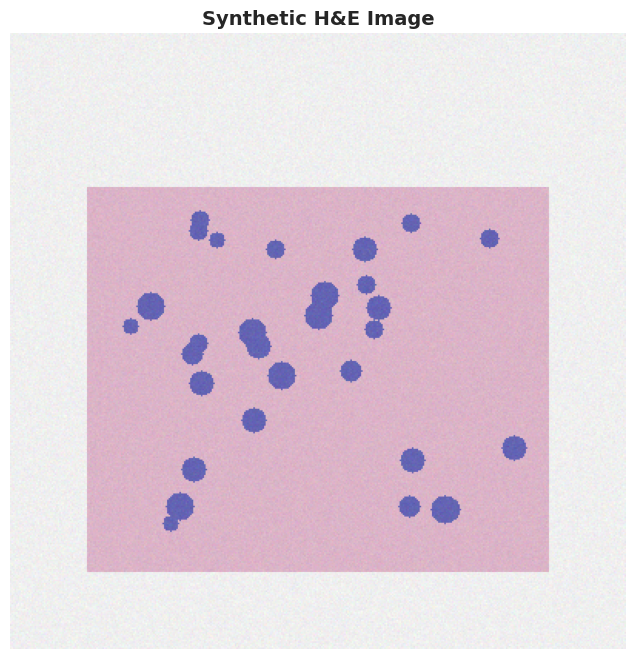

📊 Shape: (400, 400, 3)


In [ ]:
def create_synthetic_he_image(size=400, n_cells=30):
    img = np.ones((size, size, 3)) * 240
    img[100:350, 50:350] = [220, 180, 200]
    np.random.seed(42)
    for i in range(n_cells):
        y = np.random.randint(120, 330)
        x = np.random.randint(70, 330)
        radius = np.random.randint(5, 10)
        yy, xx = np.ogrid[:size, :size]
        mask = (yy - y)**2 + (xx - x)**2 <= radius**2
        img[mask] = [100, 100, 180]
    noise = np.random.normal(0, 5, img.shape)
    return np.clip(img + noise, 0, 255).astype(np.uint8)

he_image = create_synthetic_he_image()
plt.figure(figsize=(8, 8))
plt.imshow(he_image)
plt.title('Synthetic H&E Image', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()
print(f"📊 Shape: {he_image.shape}")

## 2. Color Space Analysis

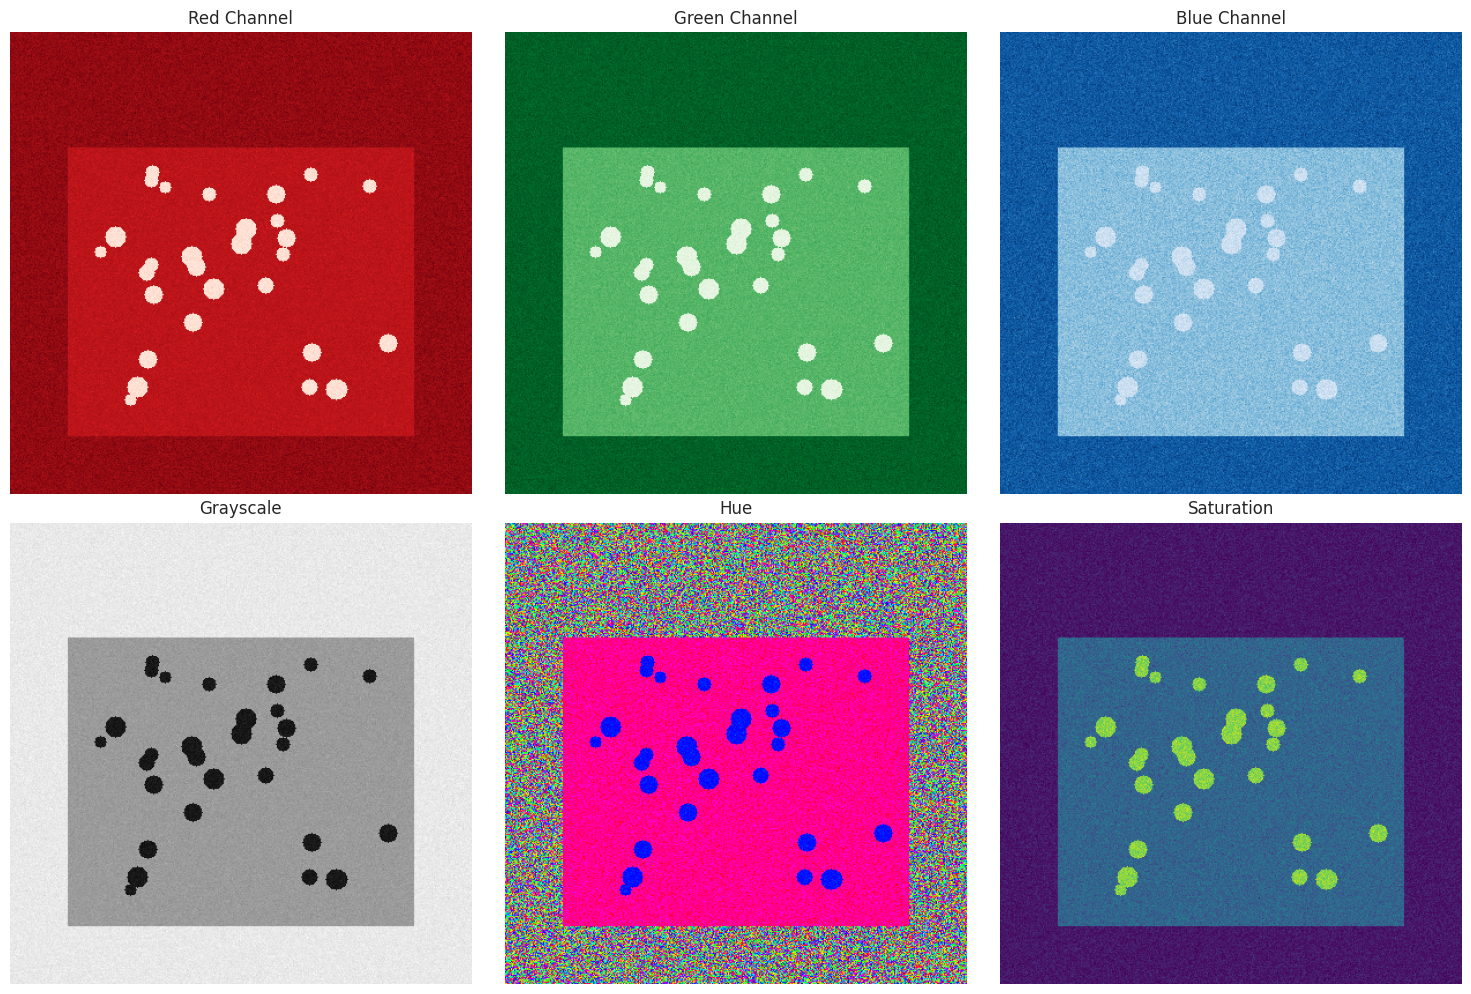

In [ ]:
gray_image = color.rgb2gray(he_image)
hsv_image = color.rgb2hsv(he_image)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].imshow(he_image[:, :, 0], cmap='Reds')
axes[0, 0].set_title('Red Channel')
axes[0, 1].imshow(he_image[:, :, 1], cmap='Greens')
axes[0, 1].set_title('Green Channel')
axes[0, 2].imshow(he_image[:, :, 2], cmap='Blues')
axes[0, 2].set_title('Blue Channel')
axes[1, 0].imshow(gray_image, cmap='gray')
axes[1, 0].set_title('Grayscale')
axes[1, 1].imshow(hsv_image[:, :, 0], cmap='hsv')
axes[1, 1].set_title('Hue')
axes[1, 2].imshow(hsv_image[:, :, 1], cmap='viridis')
axes[1, 2].set_title('Saturation')
for ax in axes.flat:
    ax.axis('off')
plt.tight_layout()
plt.show()

## 3. Cell Detection

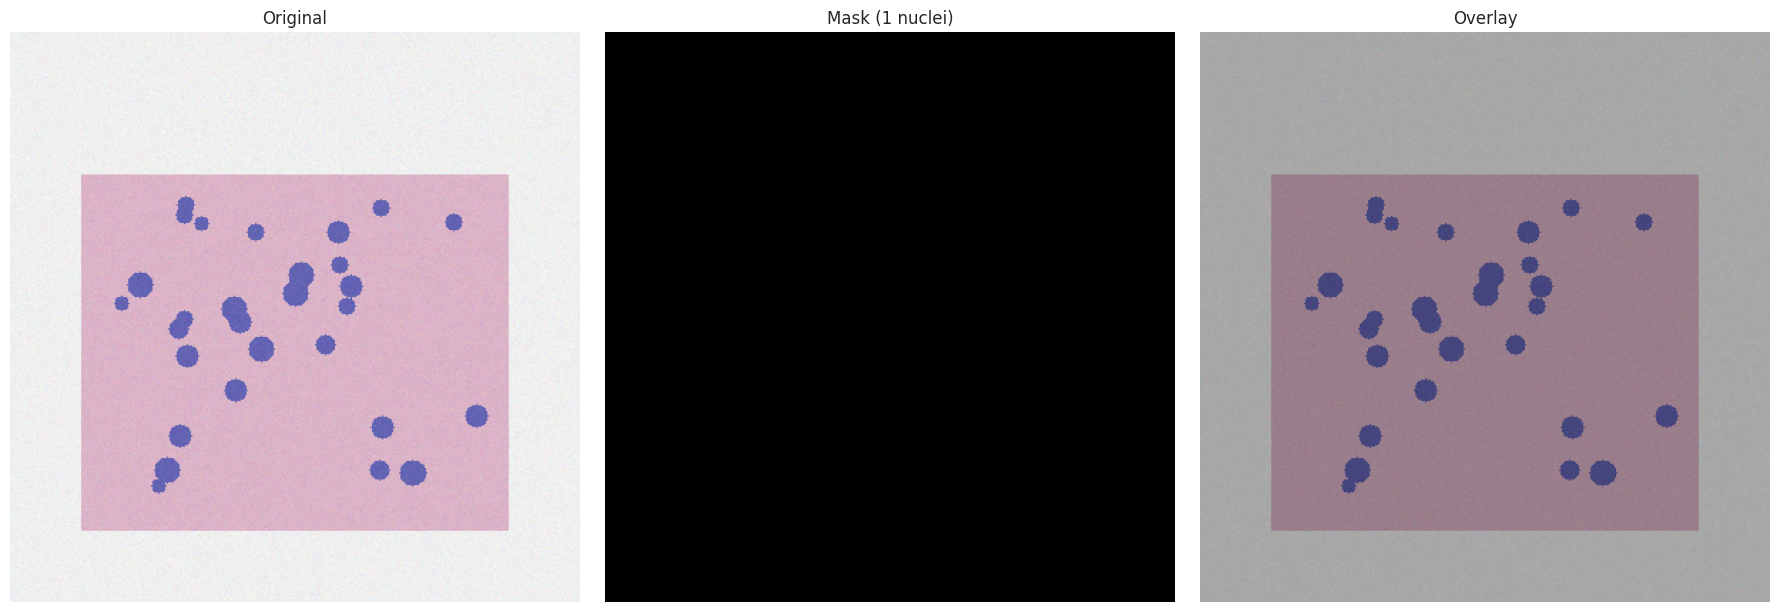

🔬 Detected 1 nuclei!


In [ ]:
blue_channel = he_image[:, :, 2]
threshold = filters.threshold_otsu(blue_channel)
nucleus_mask = blue_channel > threshold
nucleus_mask = morphology.remove_small_objects(nucleus_mask, min_size=20)
nucleus_mask = ndimage.binary_fill_holes(nucleus_mask)
nucleus_mask = morphology.binary_closing(nucleus_mask, morphology.disk(2))
labeled_nuclei = measure.label(nucleus_mask)
n_nuclei = labeled_nuclei.max()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(he_image)
axes[0].set_title('Original')
axes[1].imshow(nucleus_mask, cmap='gray')
axes[1].set_title(f'Mask ({n_nuclei} nuclei)')
axes[2].imshow(he_image)
axes[2].imshow(labeled_nuclei, cmap='nipy_spectral', alpha=0.3)
axes[2].set_title('Overlay')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()
print(f"🔬 Detected {n_nuclei} nuclei!")

## 4. Feature Extraction

In [ ]:
props = measure.regionprops_table(
    labeled_nuclei,
    intensity_image=gray_image,
    properties=['label', 'area', 'perimeter', 'centroid',
                'mean_intensity', 'eccentricity']
)
nucleus_features = pd.DataFrame(props)
nucleus_features['circularity'] = (
    4 * np.pi * nucleus_features['area'] /
    nucleus_features['perimeter']**2
)
nucleus_features.columns = ['ID', 'Area', 'Perimeter', 'Y', 'X',
                             'Intensity', 'Eccentricity', 'Circularity']
print(nucleus_features.head(10))

   ID      Area  Perimeter      Y      X  Intensity  Eccentricity  Circularity
0   1  160000.0     1596.0  199.5  199.5   0.837304           0.0      0.78934


## 5. Visualizations

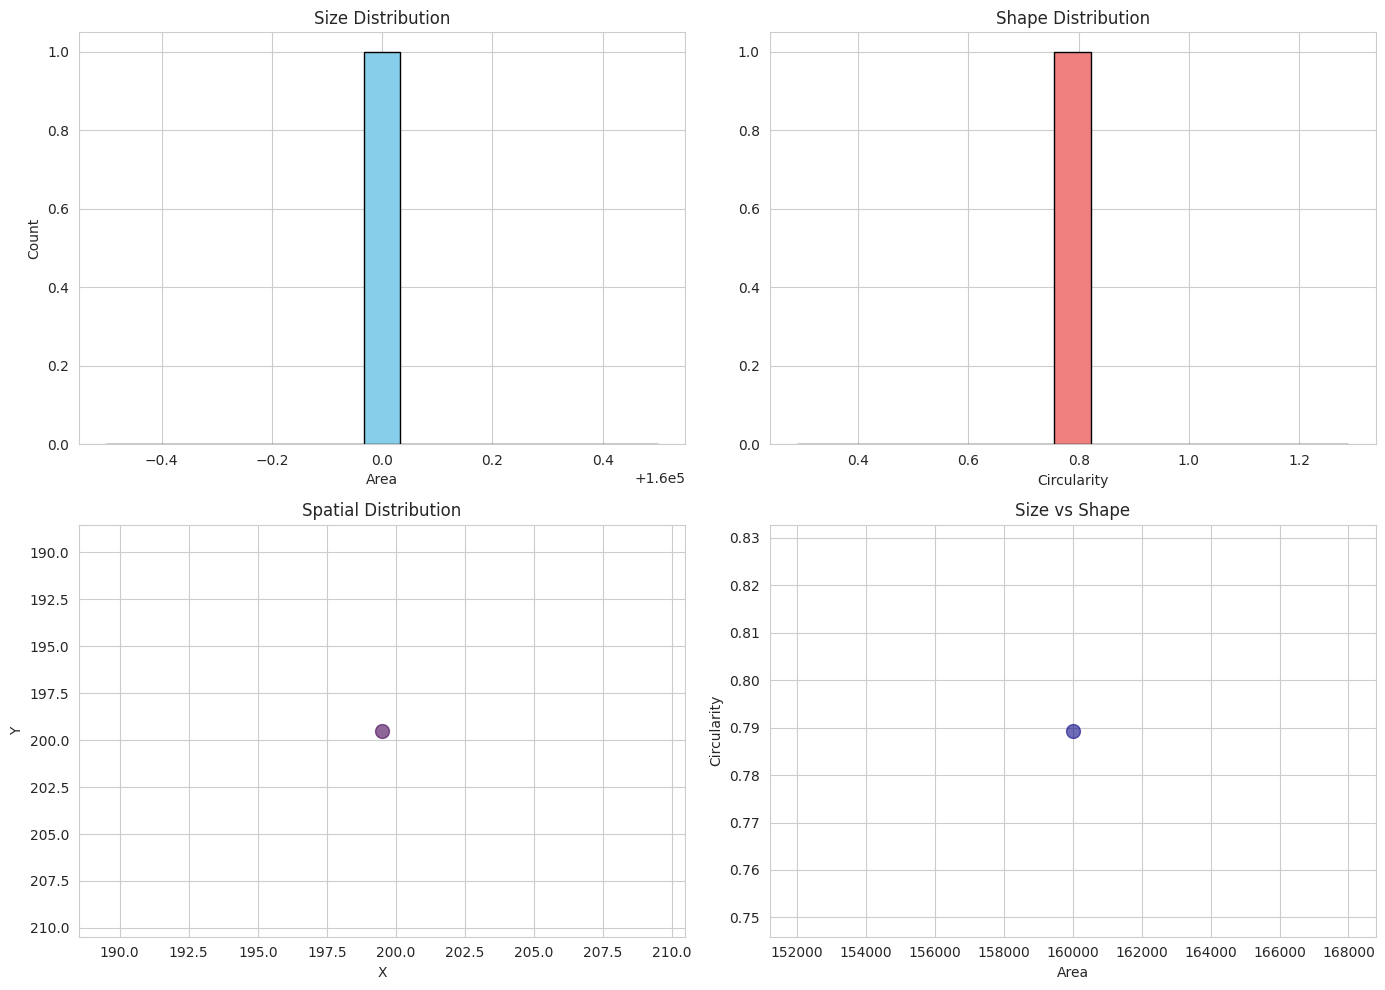

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(nucleus_features['Area'], bins=15, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Area')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Size Distribution')

axes[0, 1].hist(nucleus_features['Circularity'], bins=15, color='lightcoral', edgecolor='black')
axes[0, 1].set_xlabel('Circularity')
axes[0, 1].set_title('Shape Distribution')

axes[1, 0].scatter(nucleus_features['X'], nucleus_features['Y'],
                   c=nucleus_features['Area'], cmap='viridis', s=100, alpha=0.6)
axes[1, 0].set_xlabel('X')
axes[1, 0].set_ylabel('Y')
axes[1, 0].set_title('Spatial Distribution')
axes[1, 0].invert_yaxis()

axes[1, 1].scatter(nucleus_features['Area'], nucleus_features['Circularity'],
                   c=nucleus_features['Intensity'], cmap='plasma', s=100, alpha=0.6)
axes[1, 1].set_xlabel('Area')
axes[1, 1].set_ylabel('Circularity')
axes[1, 1].set_title('Size vs Shape')

plt.tight_layout()
plt.show()

## Summary

In [ ]:
summary = nucleus_features[['Area', 'Circularity', 'Intensity']].describe()
print("📊 SUMMARY STATISTICS:")
print(summary.round(2))
print(f"\n✅ Total cells: {len(nucleus_features)}")
print(f"✅ Avg size: {nucleus_features['Area'].mean():.1f} pixels")
print(f"✅ Avg circularity: {nucleus_features['Circularity'].mean():.2f}")

📊 SUMMARY STATISTICS:
           Area  Circularity  Intensity
count       1.0         1.00       1.00
mean   160000.0         0.79       0.84
std         NaN          NaN        NaN
min    160000.0         0.79       0.84
25%    160000.0         0.79       0.84
50%    160000.0         0.79       0.84
75%    160000.0         0.79       0.84
max    160000.0         0.79       0.84

✅ Total cells: 1
✅ Avg size: 160000.0 pixels
✅ Avg circularity: 0.79


## Exercises

1. Change `n_cells` parameter - how does it affect detection?
2. Modify the threshold method - try `filters.threshold_li()`
3. Add more features: `'solidity'`, `'major_axis_length'`
4. Filter cells by size: keep only Area > 50

---

**Next**: Part 2 - Spatial Transcriptomics